## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped,PoseStamped

import sys

from utils_notebooks import *
import cv2
import os


In [2]:
## THIS PATH MUST BE SET BY USER ()

#_path_xml = "/home/oscar/Codes/ycb_ws/src/robot_object_views/robotobject/models/MODEL_NAME/model-1_4.sdf"
#_path_model = "/home/oscar/Codes/ycb_ws/src/robot_object_views/robotobject/models"   Tenshi Version


_path_model = "/home/oscar/Codes/catkin_mio_ws/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 
_path_xml = _path_model+"/MODEL_NAME/model-1_4.sdf"  #Catkin mio version


model_database_template = """<sdf version="1.4">
  <world name="default">
    <include>
      <uri>model://MODEL_NAME</uri>
    </include>
  </world>
</sdf>"""

objs=os.listdir(_path_model)
objs.sort()



rvizを起動します．ロボットモデル、カメラ映像、ポイントクラウドが表示されています。

In [3]:

rospy.init_node("recognition")


In [4]:
rgbd = RGBD()

In [7]:
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
import moveit_commander
import moveit_msgs.msg
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')


In [6]:
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from geometry_msgs.msg import PoseStamped, Point , Quaternion
from actionlib_msgs.msg import GoalStatus

In [7]:
goal = MoveBaseGoal()
navclient = actionlib.SimpleActionClient('/move_base/move', MoveBaseAction)
navclient.wait_for_server()

def move_base_actionlib(pose):
    goal = MoveBaseGoal()
    goal.target_pose = pose

    # send message to the action server
    navclient.send_goal(goal)

    # wait for the action server to complete the order
    navclient.wait_for_result()

    # print result of navigation
    action_state = navclient.get_state()
    if action_state == GoalStatus.SUCCEEDED:
        rospy.loginfo("Navigation Succeeded.")

In [8]:
goal_x , goal_y,goal_yaw= 1.14,0.3,1.57
 
# fill ROS message
pose = PoseStamped()
pose.header.stamp = rospy.Time.now()
pose.header.frame_id = "map"
pose.pose.position = Point(goal_x, goal_y, 0)
quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
pose.pose.orientation = Quaternion(*quat)

#Takeshi neutral
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()

True

In [9]:
move_base_actionlib(pose)

[INFO] [1619184078.101052, 19.095000]: Navigation Succeeded.


In [10]:
#moveit
#MOVE IT MUST BE RUNNING. DECLARE A HEAD POSE
head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)
#WATCH OUT FOR JOINTS LIMITS (exorcist joke)
#plan and execute target pose
head.set_joint_value_target(head_val)
head.go()
### GET TF (REFERENCE FRAME FOR XTION SENSOR )
trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))

euler=tf.transformations.euler_from_quaternion(rot)

trans, euler

([1.1095014895735837, 0.4187636562723168, 0.9606106120546528],
 (-4.896370229211704e-12, 0.7850047908452344, 1.5705791475971593))

In [11]:
trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
#trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_link', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)


trans, np.rad2deg(euler)

([1.1095014895735837, 0.4187636562723168, 0.9606106120546528],
 array([-2.80541349e-10,  4.49774614e+01,  8.99875565e+01]))

In [12]:
def cart2spher(x,y,z):
    ro= np.sqrt(x**2+y**2+z**2)
    th=np.arctan2(y,x)
    phi=np.arctan2((np.sqrt(x**2+y**2)),z)
    return np.asarray((ro,th,phi))
def spher2cart(ro,th,phi):
    x= ro * np.cos(th)* np.sin(phi)
    y= ro * np.sin(th)* np.sin(phi)
    z= ro*  np.cos(th)
    return np.asarray((x,y,z))

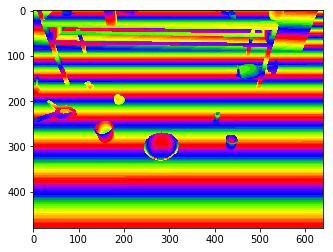

In [13]:
# ポイントクラウドを取得します Get point cloud information
points_data = rgbd.get_points()
# ポイントクラウドの深度情報を表示してみます Display the depth value of the point cloud information
plt.imshow(points_data['z'], cmap='prism')

In [14]:
px_y,px_x=-1,-200
P1= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))

px_y,px_x=-1,200
P2= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))

px_y,px_x=-150,320
P3= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))

px_y,px_x=1,320
P4= np.asarray((points_data[px_y,px_x]['x'],points_data[px_y,px_x]['y'],points_data[px_y,px_x]['z'] ))
P1,P2,P3 , P4

(array([0.20611754, 0.4096693 , 0.9482822 ], dtype=float32),
 array([-0.20442846,  0.40971228,  0.94838166], dtype=float32),
 array([1.0527783e-03, 1.9055289e-01, 1.1672843e+00], dtype=float32),
 array([ 1.2531922e-03, -5.9777272e-01,  1.3894962e+00], dtype=float32))

In [15]:
V1 =P1 - P2
V2= P3-P2
nx,ny,nz=np.cross(V2,V1)
print('look at the phi angle  in normal vector', np.rad2deg(cart2spher(nx,ny,nz))[2]-90)
print ('cartesian Normal floor',nx,ny,nz)
#plane angle to be found is same slope as the camera 

np.rad2deg(euler)[1]

#OR ELSE

('look at the phi angle  in normal vector', -45.02426008126381)
('cartesian Normal floor', 3.120934e-05, 0.089890026, 0.089966185)


44.97746141298186

In [16]:
#check if P4  its in floor plane
#normal vector = np.cross(V2,V1)
##vectors from known floor points
##P0= P1
## 0 = \vec{n} \dot \vec{P_0P}
np.dot(np.asarray((nx,ny,nz,)),P4-P1)
## if not 0 (or almost )

-0.050871033

In [17]:




ind=0
quat=rot


In [18]:
x,y,z=P1
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P1',"head_rgbd_sensor_link")
x,y,z=P2
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P2',"head_rgbd_sensor_link")
x,y,z=P3
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P3',"head_rgbd_sensor_link")
x,y,z=P4
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'P4',"head_rgbd_sensor_link")
rospy.sleep(.4)

In [19]:

trans , rot = listener.lookupTransform('/map', '/P1', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 1 wrt map',trans, np.rad2deg(euler))
trans , rot = listener.lookupTransform('/map', '/P2', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 2 wrt map',trans, np.rad2deg(euler))
trans , rot = listener.lookupTransform('/map', '/P3', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 3 wrt map',trans, np.rad2deg(euler))
trans , rot = listener.lookupTransform('/map', '/P4', rospy.Time(0))
euler=tf.transformations.euler_from_quaternion(rot)

print('point 4 wrt map',trans, np.rad2deg(euler))
gazebo_2_world

('point 1 wrt map', [1.3157643030051744, 0.7991325700557264, 1.6599046719911737e-05], array([-1.79991207e+02, -1.83204882e-02, -9.00020223e+01]))
('point 2 wrt map', [0.9052183130947785, 0.7992500161299889, -8.416038678926703e-05], array([-1.79991207e+02, -1.83204882e-02, -9.00020223e+01]))
('point 3 wrt map', [1.1107584166264897, 1.108967875639694, -0.00012346444240574073], array([-1.79991207e+02, -1.83206399e-02, -9.00020121e+01]))
('point 4 wrt map', [1.111093754661786, 1.823811070481108, 0.3996696723213144], array([-1.79991207e+02, -1.83206399e-02, -9.00020121e+01]))


<function utils_notebooks.gazebo_2_world>

In [20]:
image_data=rgbd.get_image()
mask=np.zeros((image_data.shape))
plane_mask=np.zeros((image_data.shape[0],image_data.shape[1]))


In [21]:
mask[:,:,0]=points_data['x'] - P1[0]
mask[:,:,1]=points_data['y'] - P1[1]
mask[:,:,2]=points_data['z'] - P1[2]

In [22]:
for i in range (image_data.shape[0]):
    for j in range (image_data.shape[1]):
        plane_mask[i,j]=-np.dot(np.asarray((nx,ny,nz,)),mask[i,j])

In [23]:
plane_mask=plane_mask-np.min(plane_mask)
plane_mask=plane_mask*256/np.max(plane_mask)
plane_mask.shape

(480, 640)

In [24]:
plane_mask.astype('uint8')
plane_mask.shape

(480, 640)

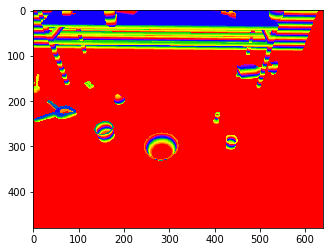

In [25]:
plt.imshow(plane_mask , cmap='prism')

In [26]:
plane_mask[200,1], plane_mask[-1,1],plane_mask[1,1]

(0.001201030002918022, 0.001295510438077637, 150.16632279674758)

In [27]:
plane_mask.shape


(480, 640)

In [28]:
ret,thresh = cv2.threshold(plane_mask,3,255,0)


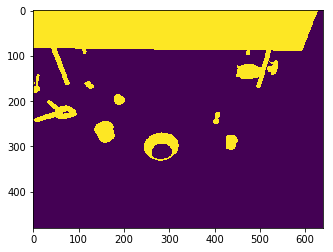

In [29]:
#FLOOR MASK
plt.imshow(thresh) 

('contour', 0, 'area', 676.0)
('contour', 1, 'area', 3619.5)
('contour', 2, 'area', 1249.0)
('contour', 3, 'area', 1572.0)
('contour', 4, 'area', 251.5)
('contour', 5, 'area', 1768.5)
('contour', 8, 'area', 413.0)
('contour', 9, 'area', 209.0)
('contour', 11, 'area', 296.0)
('contour', 12, 'area', 443.5)


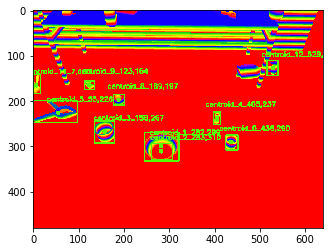

In [30]:
cv2_img=plane_mask.astype('uint8')
img=plane_mask.astype('uint8')
contours, hierarchy = cv2.findContours(thresh.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
i=0
cents=[]
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    
    if area > 200 and area < 50000 :
        print('contour',i,'area',area)
        
        boundRect = cv2.boundingRect(contour)
        #just for drawing rect, dont waste too much time on this
        img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,0,0), 2)
        # calculate moments for each contour
        xyz=[]
        
        
        for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
            for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                xyz.append(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
        xyz=np.asarray(xyz)
        cent=xyz.mean(axis=0)
        cents.append(cent)
        M = cv2.moments(contour)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
        cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
cents=np.asarray(cents)
plt.imshow(img ,cmap='prism')

In [31]:
x,y,z=cents[np.argmin(np.linalg.norm((cents-trans),axis=1))]
broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Closest_Object',"head_rgbd_sensor_link")
rospy.sleep(.2)

In [32]:
###Run again the appropriate blocks to try to look for legos on the way


###CAn you navigate through?

### Can we pick em up?


#PLEASE TRY THINGS HERE

In [33]:
cent_map,cent_quat= listener.lookupTransform('/map', 'Closest_Object',rospy.Time(0))
cent_euler=tf.transformations.euler_from_quaternion(cent_quat)


In [5]:
whole_body = moveit_commander.MoveGroupCommander('whole_body')

In [15]:
p = PoseStamped()
p.header.frame_id = 'head_rgbd_sensor_link'   ## ODOM NOR MAP SEEM TO WORK; RRT CONNECT?
p.pose.position.z = 0.2
p.pose.orientation.w = 1
whole_body.set_joint_value_target(p)
whole_body.go()

True

In [11]:
whole_body.get_current_pose()

header: 
  seq: 0
  stamp: 
    secs: 77
    nsecs: 843000000
  frame_id: "odom"
pose: 
  position: 
    x: 0.676504311018
    y: 0.0622751415497
    z: 0.672850541242
  orientation: 
    x: 0.707825938893
    y: -0.0151370914375
    z: 0.70606368904
    w: 0.0150789824458

In [52]:
p=[0.033749214744071214,
 -2.1204421063180217,
 -1.3982377978814715,
 -1.7296544561013807,
 2.135675364707808,
 0.0]#whole_body.get_current_pose()

arm.set_joint_value_target(p)
arm.go()


True

In [53]:
arm.set_named_target('neutral')
arm.go()
head.set_named_target('neutral')
head.go()

True

In [15]:
whole_body.set_joint_value_target(p)
whole_body.go()

True

In [10]:
p=whole_body.get_current_pose()

In [9]:

arm.set_named_target('neutral')
arm.go()
head.set_named_target('neutral')
head.go()

True

In [18]:
cent


NameError: name 'cent' is not defined

In [ ]:

whole_body.set_joint_value_target(p)
whole_body.go()

In [ ]:
scene = moveit_commander.PlanningSceneInterface()

In [ ]:
scene_pub = rospy.Publisher('planning_scene',
                                         moveit_msgs.msg.PlanningScene,
                                         queue_size=5)
        

In [ ]:
p_s = moveit_msgs.msg.PlanningScene()


In [ ]:
p_s.is_diff = True
color = moveit_msgs.msg.ObjectColor()
color.id = "floor"
color.color.g = 0.6
color.color.a = 0.9
p_s.object_colors.append(color)
scene_pub.publish(p_s)

In [ ]:
p = PoseStamped()
p.header.frame_id = '/map'
p.pose.position.x =cent_map[0]-.1
p.pose.position.y = cent_map[1]-.1
p.pose.position.z = cent_map[2]
p.pose.orientation.w = 1.0
scene.add_box('floor', p,(1,1,.02))

In [ ]:
whole_body.set_support_surface_name('floor')

In [ ]:
p = PoseStamped()
p.header.frame_id = '/map'
p.pose.position.x =cent_map[0]
p.pose.position.y = cent_map[1]
p.pose.position.z = cent_map[2]
p.pose.orientation.w = 1.0
scene.add_box('CLOSEST OBJ', p,(.1,.1,.05))

In [ ]:
????

In [ ]:
scene.remove_world_object()

In [ ]:
w


In [ ]:
### GO TO TAKESHI NEUTRAL
arm.set_named_target("go")
arm.go()
head.set_named_target("neutral")
head.go()

In [ ]:
p = PoseStamped()
p.header.frame_id = '/odom'
p.pose.position.x =cent_map[0]
p.pose.position.y = cent_map[1]
p.pose.position.z = cent_map[2]+.4
p.pose.orientation.w = 1.0

In [ ]:
whole_body.set_goal_tolerance(.1)

In [ ]:
whole_body.clear_pose_targets()

In [ ]:
whole_body.set_pose_target(p)


In [ ]:
whole_body.plan()